### Bag of Words

### helper.py

In [1]:
import cv2
import numpy as np 
from glob import glob
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

class ImageHelpers:
    def __init__(self):
        self.sift_object = cv2.xfeatures2d.SIFT_create()

    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return gray

    def features(self, image):
        keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        return [keypoints, descriptors]


class BOVHelpers:
    def __init__(self, n_clusters = 20):
        self.n_clusters = n_clusters
        self.kmeans_obj = KMeans(n_clusters = n_clusters)
        self.kmeans_ret = None
        self.descriptor_vstack = None
        self.mega_histogram = None
        self.clf  = SVC()    

    def cluster(self):
        """    
        cluster using KMeans algorithm, 

        """
        self.kmeans_ret = self.kmeans_obj.fit_predict(self.descriptor_vstack)

    def developVocabulary(self,n_images, descriptor_list, kmeans_ret = None):
        
        """
        Each cluster denotes a particular visual word 
        Every image can be represeted as a combination of multiple 
        visual words. The best method is to generate a sparse histogram
        that contains the frequency of occurence of each visual word 

        Thus the vocabulary comprises of a set of histograms of encompassing
        all descriptions for all images

        """

        self.mega_histogram = np.array([np.zeros(self.n_clusters) for i in range(n_images)])
        old_count = 0
        for i in range(n_images):
            l = len(descriptor_list[i])
            for j in range(l):
                if kmeans_ret is None:
                    idx = self.kmeans_ret[old_count+j]
                else:
                    idx = kmeans_ret[old_count+j]
                self.mega_histogram[i][idx] += 1
            old_count += l
        print("Vocabulary Histogram Generated")

    def standardize(self, std=None):
        """
        
        standardize is required to normalize the distribution
        wrt sample size and features. If not normalized, the classifier may become
        biased due to steep variances.

        """
        if std is None:
            self.scale = StandardScaler().fit(self.mega_histogram)
            self.mega_histogram = self.scale.transform(self.mega_histogram)
        else:
            print("STD not none. External STD supplied")
            self.mega_histogram = std.transform(self.mega_histogram)

    def formatND(self, l):
        """    
        restructures list into vstack array of shape
        M samples x N features for sklearn

        """
        print("l: ")
        print(l)
        
        vStack = np.array(l[0])
        for remaining in l[1:]:
            vStack = np.vstack((vStack, remaining))
        self.descriptor_vstack = vStack.copy()
        return vStack

    def train(self, train_labels):
        """
        uses sklearn.svm.SVC classifier (SVM) 


        """
        print("Training SVM")
        print(self.clf)
        print("Train labels", train_labels)
        self.clf.fit(self.mega_histogram, train_labels)
        print("Training completed")

    def predict(self, iplist):
        predictions = self.clf.predict(iplist)
        return predictions

    def plotHist(self, vocabulary = None):
        print("Plotting histogram")
        if vocabulary is None:
            vocabulary = self.mega_histogram

        x_scalar = np.arange(self.n_clusters)
        y_scalar = np.array([abs(np.sum(vocabulary[:,h], dtype=np.int32)) for h in range(self.n_clusters)])

        print(y_scalar)

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()

class FileHelpers:

    def __init__(self):
        pass

    def getFiles(self, path):
        """
        - returns  a dictionary of all files 
        having key => value as  objectname => image path

        - returns total number of files.

        """
        imlist = {}
        count = 0
        for each in glob(path + "*"):
            word = each.split("/")[-1]
            print(" #### Reading image category ", word, " ##### ")
            imlist[word] = []
            for imagefile in glob(path+word+"/*"):
                print("Reading file ", imagefile)
                im = cv2.imread(imagefile, 0)
                imlist[word].append(im)
                count +=1 

        return [imlist, count]



### kmeans.py

[1 2 2 0 2 0 1 2 1 0 0 0 2 2 0 2 2 2 2 0 0 1 0 1 0 2 1 0 0 1 2 0 2 2 1 1 0
 2 1 1 2 1 0 0 0 0 1 1 0 0 0 0 0 2 2 1 1 1 1 0 2 0 0 0 2 2 1 2 1 2 1 2 0 0
 2 2 0 2 2 0 1 1 0 1 1 2 2 2 0 2 0 1 1 1 2 0 0 1 0 1 2 1 1 1 2 0 0 1 0 2 0
 1 2 2 1 2 2 1 0 2 2 2 0 1 0 2 0 2 0 2 0 2 0 0 1 2 2 1 2 2 2 2 0 0 2 2 0 0
 2 2 1 1 1 2 1 1 1 2 2 0 1 2 0 2 2 0 0 2 1 1 2 1 1 0 2 2 1 0 0 0 0 0 1 2 1
 1 1 2 2 0 1 2 2 2 0 0 1 1 0 2 1 0 2 2 2 0 0 1 0 1 1 1 1 1 1 0 1 1 0 2 1 1
 2 2 2 1 2 0 1 1 0 1 2 0 2 2 0 2 2 2 1 1 2 1 2 2 1 0 2 1 0 2 2 2 0 0 2 0 0
 2 0 1 2 1 1 0 0 2 2 2 1 1 2 0 0 1 0 0 2 0 2 2 2 2 1 0 2 0 0 1 0 0 1 1 2 1
 1 1 1 1 1 2 1 1 0 2 1 1 2 1 2 2 0 0 0 0 1 2 2 2 2 0 0 0 2 2 2 2 2 1 1 2 1
 1 0 1 2 0 1 0 2 2 1 2 2 1 1 1 1 1 2 1 2 0 0 1 1 0 0 0 0 1 1 2 1 2 2 2 0 0
 1 1 0 1 2 2 0 2 0 1 0 2 0 0 2 1 0 0 1 0 2 1 0 2 1 0 2 1 1 1 1 1 0 1 1 0 0
 1 1 0 2 2 2 1 2 1 2 0 0 1 2 0 0 0 2 1 1 1 0 1 1 0 0 0 2 2 2 0 2 2 0 2 2 2
 2 2 2 0 2 0 2 2 2 0 1 0 0 0 1 2 1 1 0 0 1 1 2 2 2 1 1 2 1 2 1 2 1 2 1 0 1
 2 1 1 0 2 2 1 0 1 2 1 1 

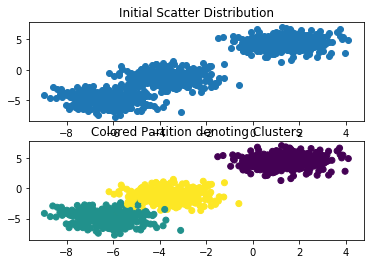

In [2]:
"""
Using SKLearns API for performing Kmeans clustering.
Using sklearn.datasets.make_blobs for generating randomized gaussians
for clustering.

"""

import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs 

# create a dataset sample space that will be used
# to test KMeans. Use function : make_blobs
# 

n_samples = 1000
n_features = 5;
n_clusters = 3;

# aint this sweet 
X, y = make_blobs(n_samples, n_features) 
# X => array of shape [nsamples,nfeatures] ;;; y => array of shape[nsamples]

# X : generated samples, y : integer labels for cluster membership of each sample
# 
# 

# performing KMeans clustering

ret =  KMeans(n_clusters = n_clusters).fit_predict(X)
print(ret)

__, ax = plt.subplots(2)
ax[0].scatter(X[:,0], X[:,1])
ax[0].set_title("Initial Scatter Distribution")
ax[1].scatter(X[:,0], X[:,1], c=ret)
ax[1].set_title("Colored Partition denoting Clusters")
# plt.scatter
plt.show()



### Bag.py

In [3]:
import cv2
import numpy as np 
from glob import glob 
import argparse
from helpers import *
from matplotlib import pyplot as plt 


class BOV:
    def __init__(self, no_clusters):
        self.no_clusters = no_clusters
        self.train_path = None
        self.test_path = None
        self.im_helper = ImageHelpers()
        self.bov_helper = BOVHelpers(no_clusters)
        self.file_helper = FileHelpers()
        self.images = None
        self.trainImageCount = 0
        self.train_labels = np.array([])
        self.name_dict = {}
        self.descriptor_list = []

    def trainModel(self):
        """
        This method contains the entire module 
        required for training the bag of visual words model

        Use of helper functions will be extensive.

        """

        # read file. prepare file lists.
        self.images, self.trainImageCount = self.file_helper.getFiles(self.train_path)
        # extract SIFT Features from each image
        print("images: ", self.images)
        print("train image count: ", self.trainImageCount)
        label_count = 0 
        for word, imlist in self.images.items():
            self.name_dict[str(label_count)] = word
            print("Computing Features for ", word)
            print("List: ", imlist)
            for im in imlist:
                # cv2.imshow("im", im)
                # cv2.waitKey()
                self.train_labels = np.append(self.train_labels, label_count)
                kp, des = self.im_helper.features(im)
                self.descriptor_list.append(des)

            label_count += 1


        # perform clustering
        
        print(self.descriptor_list)
        bov_descriptor_stack = self.bov_helper.formatND(self.descriptor_list)
        self.bov_helper.cluster()
        self.bov_helper.developVocabulary(n_images = self.trainImageCount, descriptor_list=self.descriptor_list)

        # show vocabulary trained
        # self.bov_helper.plotHist()
 

        self.bov_helper.standardize()
        self.bov_helper.train(self.train_labels)
        print("trainModel DONE.")


    def recognize(self,test_img, test_image_path=None):

        """ 
        This method recognizes a single image 
        It can be utilized individually as well.


        """

        kp, des = self.im_helper.features(test_img)
        # print kp
        print(des.shape)

        # generate vocab for test image
        vocab = np.array( [[ 0 for i in range(self.no_clusters)]])
        # locate nearest clusters for each of 
        # the visual word (feature) present in the image
        
        # test_ret =<> return of kmeans nearest clusters for N features
        test_ret = self.bov_helper.kmeans_obj.predict(des)
        # print test_ret

        # print vocab
        for each in test_ret:
            vocab[0][each] += 1

        print(vocab)
        # Scale the features
        vocab = self.bov_helper.scale.transform(vocab)

        # predict the class of the image
        lb = self.bov_helper.clf.predict(vocab)
        # print "Image belongs to class : ", self.name_dict[str(int(lb[0]))]
        return lb



    def testModel(self):
        """ 
        This method is to test the trained classifier

        read all images from testing path 
        use BOVHelpers.predict() function to obtain classes of each image

        """

        self.testImages, self.testImageCount = self.file_helper.getFiles(self.test_path)

        predictions = []

        for word, imlist in self.testImages.items():
            print("processing " ,word)
            for im in imlist:
                # print imlist[0].shape, imlist[1].shape
                print(im.shape)
                cl = self.recognize(im)
                print(cl)
                predictions.append({
                    'image':im,
                    'class':cl,
                    'object_name':self.name_dict[str(int(cl[0]))]
                    })

        print(predictions)
        for each in predictions:
            # cv2.imshow(each['object_name'], each['image'])
            # cv2.waitKey()
            # cv2.destroyWindow(each['object_name'])
            # 
            plt.imshow(cv2.cvtColor(each['image'], cv2.COLOR_GRAY2RGB))
            plt.title(each['object_name'])
            plt.show()


    def print_vars(self):
        pass
    
    def start(self, train_path, test_path):
        # set training paths
        self.train_path = train_path
        # set testing paths
        self.test_path = test_path
        # train the model
        self.trainModel()
        # test model
        self.testModel()


# if __name__ == '__main__':

#     # parse cmd args
#     parser = argparse.ArgumentParser(
#             description=" Bag of visual words example"
#         )
#     parser.add_argument('--train_path', action="store", dest="train_path", required=True)
#     parser.add_argument('--test_path', action="store", dest="test_path", required=True)

#     args =  vars(parser.parse_args())
#     print(args)

    
#     bov = BOV(no_clusters=100)

#     # set training paths
#     bov.train_path = args['train_path'] 
#     # set testing paths
#     bov.test_path = args['test_path'] 
#     # train the model
#     bov.trainModel()
#     # test model
#     bov.testModel()


### Fruits

In [6]:
bov = BOV(no_clusters=100)
#bov.start("images\\train\\", "images\\test\\")
bov.start("../../ex3/FIDS30/train/", "../../ex3/FIDS30/test/")

big word:  ../../ex3/FIDS30/train/acerolas
 #### Reading image category  acerolas  ##### 
globpath: ['../../ex3/FIDS30/train/acerolas\\1.jpg', '../../ex3/FIDS30/train/acerolas\\10.jpg', '../../ex3/FIDS30/train/acerolas\\12.jpg', '../../ex3/FIDS30/train/acerolas\\15.jpg', '../../ex3/FIDS30/train/acerolas\\16.jpg', '../../ex3/FIDS30/train/acerolas\\18.jpg', '../../ex3/FIDS30/train/acerolas\\19.jpg', '../../ex3/FIDS30/train/acerolas\\21.jpg', '../../ex3/FIDS30/train/acerolas\\22.jpg', '../../ex3/FIDS30/train/acerolas\\23.jpg', '../../ex3/FIDS30/train/acerolas\\25.jpg', '../../ex3/FIDS30/train/acerolas\\29.jpg', '../../ex3/FIDS30/train/acerolas\\3.jpg', '../../ex3/FIDS30/train/acerolas\\30.jpg', '../../ex3/FIDS30/train/acerolas\\33.jpg', '../../ex3/FIDS30/train/acerolas\\34.jpg', '../../ex3/FIDS30/train/acerolas\\35.jpg', '../../ex3/FIDS30/train/acerolas\\36.jpg', '../../ex3/FIDS30/train/acerolas\\5.jpg']
word:  acerolas
Reading file  ../../ex3/FIDS30/train/acerolas\1.jpg
Reading file  ../

Reading file  ../../ex3/FIDS30/train/avocados\3.jpg
Reading file  ../../ex3/FIDS30/train/avocados\32.jpg
Reading file  ../../ex3/FIDS30/train/avocados\34.jpg
Reading file  ../../ex3/FIDS30/train/avocados\38.jpg
Reading file  ../../ex3/FIDS30/train/avocados\4.jpg
Reading file  ../../ex3/FIDS30/train/avocados\40.jpg
Reading file  ../../ex3/FIDS30/train/avocados\6.jpg
Reading file  ../../ex3/FIDS30/train/avocados\7.jpg
Reading file  ../../ex3/FIDS30/train/avocados\8.jpg
Reading file  ../../ex3/FIDS30/train/avocados\9.jpg
big word:  ../../ex3/FIDS30/train/bananas
 #### Reading image category  bananas  ##### 
globpath: ['../../ex3/FIDS30/train/bananas\\1.jpg', '../../ex3/FIDS30/train/bananas\\10.jpg', '../../ex3/FIDS30/train/bananas\\11.jpg', '../../ex3/FIDS30/train/bananas\\12.jpg', '../../ex3/FIDS30/train/bananas\\13.jpg', '../../ex3/FIDS30/train/bananas\\14.jpg', '../../ex3/FIDS30/train/bananas\\15.jpg', '../../ex3/FIDS30/train/bananas\\16.jpg', '../../ex3/FIDS30/train/bananas\\17.jpg', 

Reading file  ../../ex3/FIDS30/train/blueberries\16.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\2.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\20.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\26.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\27.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\29.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\3.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\31.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\34.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\37.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\4.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\40.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\42.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\44.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\47.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\48.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\5.jpg
Reading file  ../../ex3/FIDS30/train/blueberries\6.j

Reading file  ../../ex3/FIDS30/train/figs\22.jpg
Reading file  ../../ex3/FIDS30/train/figs\23.jpg
Reading file  ../../ex3/FIDS30/train/figs\25.jpg
Reading file  ../../ex3/FIDS30/train/figs\27.jpg
Reading file  ../../ex3/FIDS30/train/figs\28.jpg
Reading file  ../../ex3/FIDS30/train/figs\29.jpg
Reading file  ../../ex3/FIDS30/train/figs\3.jpg
Reading file  ../../ex3/FIDS30/train/figs\30.jpg
Reading file  ../../ex3/FIDS30/train/figs\32.jpg
Reading file  ../../ex3/FIDS30/train/figs\36.jpg
Reading file  ../../ex3/FIDS30/train/figs\4.jpg
Reading file  ../../ex3/FIDS30/train/figs\8.jpg
Reading file  ../../ex3/FIDS30/train/figs\9.jpg
big word:  ../../ex3/FIDS30/train/grapefruits
 #### Reading image category  grapefruits  ##### 
globpath: ['../../ex3/FIDS30/train/grapefruits\\0.jpg', '../../ex3/FIDS30/train/grapefruits\\1.jpg', '../../ex3/FIDS30/train/grapefruits\\10.jpg', '../../ex3/FIDS30/train/grapefruits\\16.jpg', '../../ex3/FIDS30/train/grapefruits\\17.jpg', '../../ex3/FIDS30/train/grapefru

Reading file  ../../ex3/FIDS30/train/guava\9.jpg
big word:  ../../ex3/FIDS30/train/kiwifruit
 #### Reading image category  kiwifruit  ##### 
globpath: ['../../ex3/FIDS30/train/kiwifruit\\0.jpg', '../../ex3/FIDS30/train/kiwifruit\\1.jpg', '../../ex3/FIDS30/train/kiwifruit\\10.jpg', '../../ex3/FIDS30/train/kiwifruit\\11.jpg', '../../ex3/FIDS30/train/kiwifruit\\13.jpg', '../../ex3/FIDS30/train/kiwifruit\\14.jpg', '../../ex3/FIDS30/train/kiwifruit\\16.jpg', '../../ex3/FIDS30/train/kiwifruit\\17.jpg', '../../ex3/FIDS30/train/kiwifruit\\18.jpg', '../../ex3/FIDS30/train/kiwifruit\\19.jpg', '../../ex3/FIDS30/train/kiwifruit\\21.jpg', '../../ex3/FIDS30/train/kiwifruit\\22.jpg', '../../ex3/FIDS30/train/kiwifruit\\25.jpg', '../../ex3/FIDS30/train/kiwifruit\\27.jpg', '../../ex3/FIDS30/train/kiwifruit\\3.jpg', '../../ex3/FIDS30/train/kiwifruit\\30.jpg', '../../ex3/FIDS30/train/kiwifruit\\36.jpg', '../../ex3/FIDS30/train/kiwifruit\\37.jpg', '../../ex3/FIDS30/train/kiwifruit\\38.jpg', '../../ex3/FIDS

Reading file  ../../ex3/FIDS30/train/mangos\10.jpg
Reading file  ../../ex3/FIDS30/train/mangos\11.jpg
Reading file  ../../ex3/FIDS30/train/mangos\12.jpg
Reading file  ../../ex3/FIDS30/train/mangos\13.jpg
Reading file  ../../ex3/FIDS30/train/mangos\15.jpg
Reading file  ../../ex3/FIDS30/train/mangos\16.jpg
Reading file  ../../ex3/FIDS30/train/mangos\19.jpg
Reading file  ../../ex3/FIDS30/train/mangos\2.jpg
Reading file  ../../ex3/FIDS30/train/mangos\20.jpg
Reading file  ../../ex3/FIDS30/train/mangos\22.jpg
Reading file  ../../ex3/FIDS30/train/mangos\23.jpg
Reading file  ../../ex3/FIDS30/train/mangos\25.jpg
Reading file  ../../ex3/FIDS30/train/mangos\26.jpg
Reading file  ../../ex3/FIDS30/train/mangos\28.jpg
Reading file  ../../ex3/FIDS30/train/mangos\29.jpg
Reading file  ../../ex3/FIDS30/train/mangos\33.jpg
Reading file  ../../ex3/FIDS30/train/mangos\35.jpg
Reading file  ../../ex3/FIDS30/train/mangos\36.jpg
Reading file  ../../ex3/FIDS30/train/mangos\38.jpg
Reading file  ../../ex3/FIDS30/t

Reading file  ../../ex3/FIDS30/train/peaches\14.jpg
Reading file  ../../ex3/FIDS30/train/peaches\18.jpg
Reading file  ../../ex3/FIDS30/train/peaches\2.jpg
Reading file  ../../ex3/FIDS30/train/peaches\20.jpg
Reading file  ../../ex3/FIDS30/train/peaches\21.jpg
Reading file  ../../ex3/FIDS30/train/peaches\22.jpg
Reading file  ../../ex3/FIDS30/train/peaches\25.jpg
Reading file  ../../ex3/FIDS30/train/peaches\26.jpg
Reading file  ../../ex3/FIDS30/train/peaches\3.jpg
Reading file  ../../ex3/FIDS30/train/peaches\30.jpg
Reading file  ../../ex3/FIDS30/train/peaches\31.jpg
Reading file  ../../ex3/FIDS30/train/peaches\32.jpg
Reading file  ../../ex3/FIDS30/train/peaches\39.jpg
Reading file  ../../ex3/FIDS30/train/peaches\4.jpg
Reading file  ../../ex3/FIDS30/train/peaches\41.jpg
Reading file  ../../ex3/FIDS30/train/peaches\43.jpg
Reading file  ../../ex3/FIDS30/train/peaches\7.jpg
Reading file  ../../ex3/FIDS30/train/peaches\8.jpg
Reading file  ../../ex3/FIDS30/train/peaches\9.jpg
big word:  ../../e

Reading file  ../../ex3/FIDS30/train/pomegranates\20.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\21.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\22.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\23.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\26.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\29.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\3.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\30.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\33.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\34.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\36.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\4.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\5.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\6.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\7.jpg
Reading file  ../../ex3/FIDS30/train/pomegranates\8.jpg
big word:  ../../ex3/FIDS30/train/raspberries
 #### Reading image category  raspberries  #####

Reading file  ../../ex3/FIDS30/train/tomatoes\14.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\16.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\17.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\18.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\19.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\2.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\20.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\21.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\22.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\23.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\26.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\27.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\28.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\29.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\3.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\31.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\32.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\34.jpg
Reading file  ../../ex3/FIDS30/train/tomatoes\35

Computing Features for  apples
List:  [array([[120, 157, 175, ..., 162, 165, 166],
       [144, 167, 175, ..., 158, 164, 169],
       [160, 168, 167, ..., 165, 170, 179],
       ...,
       [ 32,  32,  34, ..., 128, 129, 129],
       [ 33,  32,  33, ..., 127, 127, 126],
       [ 33,  32,  33, ..., 126, 126, 125]], dtype=uint8), array([[254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       ...,
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254]], dtype=uint8), array([[196, 196, 196, ..., 174, 171, 173],
       [198, 196, 194, ..., 173, 176, 176],
       [195, 194, 193, ..., 173, 176, 177],
       ...,
       [246, 245, 244, ..., 221, 221, 219],
       [246, 246, 245, ..., 222, 222, 221],
       [246, 246, 245, ..., 223, 223, 222]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],


error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\opencv_contrib-3.4.1\modules\xfeatures2d\src\sift.cpp:1121: error: (-5) image is empty or has incorrect depth (!=CV_8U) in function cv::xfeatures2d::SIFT_Impl::detectAndCompute


### Cars

In [7]:
bov = BOV(no_clusters=100)
#bov.start("images\\train\\", "images\\test\\")
bov.start("../../ex3/CarData/TrainImages/", "../../ex3/CarData/TestImages/")

big word:  ../../ex3/CarData/TrainImages/negative
 #### Reading image category  negative  ##### 
globpath: ['../../ex3/CarData/TrainImages/negative\\neg-0.pgm', '../../ex3/CarData/TrainImages/negative\\neg-1.pgm', '../../ex3/CarData/TrainImages/negative\\neg-10.pgm', '../../ex3/CarData/TrainImages/negative\\neg-100.pgm', '../../ex3/CarData/TrainImages/negative\\neg-101.pgm', '../../ex3/CarData/TrainImages/negative\\neg-102.pgm', '../../ex3/CarData/TrainImages/negative\\neg-103.pgm', '../../ex3/CarData/TrainImages/negative\\neg-104.pgm', '../../ex3/CarData/TrainImages/negative\\neg-105.pgm', '../../ex3/CarData/TrainImages/negative\\neg-106.pgm', '../../ex3/CarData/TrainImages/negative\\neg-107.pgm', '../../ex3/CarData/TrainImages/negative\\neg-108.pgm', '../../ex3/CarData/TrainImages/negative\\neg-109.pgm', '../../ex3/CarData/TrainImages/negative\\neg-11.pgm', '../../ex3/CarData/TrainImages/negative\\neg-110.pgm', '../../ex3/CarData/TrainImages/negative\\neg-111.pgm', '../../ex3/CarData

Reading file  ../../ex3/CarData/TrainImages/negative\neg-303.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-304.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-305.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-306.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-307.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-308.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-309.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-31.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-310.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-311.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-312.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-313.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-314.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-315.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-316.pgm
Reading file  ../../ex3/Ca

Reading file  ../../ex3/CarData/TrainImages/negative\neg-96.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-97.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-98.pgm
Reading file  ../../ex3/CarData/TrainImages/negative\neg-99.pgm
big word:  ../../ex3/CarData/TrainImages/positive
 #### Reading image category  positive  ##### 
globpath: ['../../ex3/CarData/TrainImages/positive\\pos-0.pgm', '../../ex3/CarData/TrainImages/positive\\pos-1.pgm', '../../ex3/CarData/TrainImages/positive\\pos-10.pgm', '../../ex3/CarData/TrainImages/positive\\pos-100.pgm', '../../ex3/CarData/TrainImages/positive\\pos-101.pgm', '../../ex3/CarData/TrainImages/positive\\pos-102.pgm', '../../ex3/CarData/TrainImages/positive\\pos-103.pgm', '../../ex3/CarData/TrainImages/positive\\pos-104.pgm', '../../ex3/CarData/TrainImages/positive\\pos-105.pgm', '../../ex3/CarData/TrainImages/positive\\pos-106.pgm', '../../ex3/CarData/TrainImages/positive\\pos-107.pgm', '../../ex3/CarData/TrainImages/posit

Reading file  ../../ex3/CarData/TrainImages/positive\pos-318.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-319.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-32.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-320.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-321.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-322.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-323.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-324.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-325.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-326.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-327.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-328.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-329.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-33.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-330.pgm
Reading file  ../../ex3/Car

Reading file  ../../ex3/CarData/TrainImages/positive\pos-73.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-74.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-75.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-76.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-77.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-78.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-79.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-8.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-80.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-81.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-82.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-83.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-84.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-85.pgm
Reading file  ../../ex3/CarData/TrainImages/positive\pos-86.pgm
Reading file  ../../ex3/CarData/TrainImag

Computing Features for  positive
List:  [array([[153, 153, 153, ..., 193, 193, 193],
       [131, 153, 131, ..., 193, 166, 193],
       [131, 131, 153, ..., 206, 193, 193],
       ...,
       [242, 242, 242, ..., 224, 206, 224],
       [242, 242, 242, ..., 224, 224, 206],
       [224, 224, 224, ..., 206, 224, 224]], dtype=uint8), array([[ 87,  93, 112, ..., 173, 193, 155],
       [112, 121, 144, ..., 183, 206, 183],
       [ 64,  72, 112, ..., 183, 219, 183],
       ...,
       [219, 219, 219, ..., 219, 219, 206],
       [206, 206, 206, ..., 219, 219, 219],
       [193, 193, 193, ..., 206, 206, 193]], dtype=uint8), array([[220, 188, 124, ..., 115, 115,  92],
       [220, 171, 132, ..., 108, 108, 108],
       [227, 188, 171, ..., 115, 108,  92],
       ...,
       [253, 243, 243, ..., 188, 196, 196],
       [253, 253, 253, ..., 196, 188, 188],
       [253, 253, 253, ..., 180, 180, 188]], dtype=uint8), array([[ 57,  70,  57, ...,   9,   9,   9],
       [ 57,  57,  70, ...,   9,   9,  14]

[array([[49., 14.,  5., ...,  0.,  0.,  0.],
       [ 6.,  2.,  1., ...,  5.,  4., 56.],
       [59.,  1.,  0., ..., 34.,  1., 22.],
       ...,
       [29.,  7.,  0., ...,  0.,  0.,  3.],
       [ 1.,  1.,  0., ...,  0.,  0.,  1.],
       [ 2.,  1.,  1., ...,  1.,  0.,  2.]], dtype=float32), array([[  0.,   0.,   0., ...,  10.,   2.,   3.],
       [  0.,   0.,   4., ...,  16.,  44., 103.],
       [  1.,   2.,  41., ...,  51.,  61.,   5.],
       ...,
       [  7.,  15., 113., ...,  64.,  69.,   0.],
       [ 14.,  42.,  83., ...,   4.,  14.,   4.],
       [ 60.,  21.,  22., ...,   4.,   1.,   0.]], dtype=float32), array([[99.,  3.,  0., ...,  4., 15.,  9.],
       [30.,  3.,  0., ..., 14.,  2.,  8.],
       [ 3.,  1.,  1., ...,  0.,  5., 13.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  2., 12.],
       [21.,  2.,  0., ...,  0.,  0.,  0.],
       [27., 62., 50., ...,  0.,  0.,  0.]], dtype=float32), array([[  0.,   0.,   2., ...,  20.,   2.,   0.],
       [  3.,   0.,   0., ...,   3

[array([[49., 14.,  5., ...,  0.,  0.,  0.],
       [ 6.,  2.,  1., ...,  5.,  4., 56.],
       [59.,  1.,  0., ..., 34.,  1., 22.],
       ...,
       [29.,  7.,  0., ...,  0.,  0.,  3.],
       [ 1.,  1.,  0., ...,  0.,  0.,  1.],
       [ 2.,  1.,  1., ...,  1.,  0.,  2.]], dtype=float32), array([[  0.,   0.,   0., ...,  10.,   2.,   3.],
       [  0.,   0.,   4., ...,  16.,  44., 103.],
       [  1.,   2.,  41., ...,  51.,  61.,   5.],
       ...,
       [  7.,  15., 113., ...,  64.,  69.,   0.],
       [ 14.,  42.,  83., ...,   4.,  14.,   4.],
       [ 60.,  21.,  22., ...,   4.,   1.,   0.]], dtype=float32), array([[99.,  3.,  0., ...,  4., 15.,  9.],
       [30.,  3.,  0., ..., 14.,  2.,  8.],
       [ 3.,  1.,  1., ...,  0.,  5., 13.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  2., 12.],
       [21.,  2.,  0., ...,  0.,  0.,  0.],
       [27., 62., 50., ...,  0.,  0.,  0.]], dtype=float32), array([[  0.,   0.,   2., ...,  20.,   2.,   0.],
       [  3.,   0.,   0., ...,   3

ValueError: all the input array dimensions except for the concatenation axis must match exactly